# SSVEP Decoding from EEG Signals using Traditional Machine Learning

## **1. Introduction**

This notebook demonstrates a comprehensive pipeline for decoding **Steady-State Visual Evoked Potentials (SSVEP)** from Electroencephalography (EEG) signals. SSVEPs are brain responses to rhythmic visual stimuli, often used in Brain-Computer Interface (BCI) applications. We'll utilize the **EEG-Notebooks** dataset (specifically the `visual-SSVEP` experiment) and apply various traditional machine learning techniques with the help of `MNE-Python`, `Pyriemann`, and `Scikit-learn` to classify the target stimulus frequency (20 Hz vs. 30 Hz).

This notebook is derived from [EEG-Notebooks Project Homepage](https://neurotechx.github.io/eeg-notebooks_v0.2/auto_examples/visual_ssvep/02r__ssvep_decoding.html#setup)

**What is EEG-Notebooks?**

It is a project that aims to make cognitive neuroscience and neurotechnology more accessible, cost-effective, and scalable. They do this by providing a collection of classic EEG experiments implemented in `Python 3` using `Jupyter notebooks`.

## **2. Setup and Library Imports**

First, let's import all the necessary libraries. We'll organize them by their primary function.

In [7]:
!git clone https://github.com/NeuroTechX/eeg-notebooks.git
%cd eeg-notebooks
!pip install -e .

C:\Users\arwaa\Desktop\Jupeter\eeg-notebooks


Cloning into 'eeg-notebooks'...


Obtaining file:///C:/Users/arwaa/Desktop/Jupeter/eeg-notebooks
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
  Using cached pyserial-3.5-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pyriemann to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
   ---------------------------------------- 0.0/115.6 kB ? eta -:--:--
   ---------- ---------

In [9]:
!pip install numpy pandas matplotlib mne

In [11]:
!pip install brainflow muselsl pylsl pyriemann

  Using cached pexpect-4.9.0-py2.py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/31.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.0 MB 2.0 MB/s eta 0:00:16
   ---------------------------------------- 0.1/31.0 MB 1.7 MB/s eta 0:00:19
   ---------------------------------------- 0.2/31.0 MB 1.6 MB/s eta 0:00:19
   ---------------------------------------- 0.2/31.0 MB 1.7 MB/s eta 0:00:19
    --------------------------------------- 0.5/31.0 MB 2.2 MB/s eta 0:00:14
    --------------------------------------- 0.6/31.0 MB 2.2 MB/s eta 0:00:14
   - -------------------------------------- 0.8/31.0 MB 2.5 MB/s eta 0:00:13
   - -------------------------------------- 1.0/31.0 MB 2.7 MB/s eta 0:00:12
   - -------------------------------------- 1.1/31.0 MB 2.8 MB/s eta 0:00:11
   - -------------------------------------- 1.3/31.0 MB 2.9 MB/s eta 0:00:11
   - -------------------------------------- 1.5/31.0 MB 3.0 MB/s eta 0:00:10
   -- ---------

In [12]:
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE-Python for EEG data processing
from mne import Epochs, find_events
from mne.decoding import Vectorizer # Not directly used in this specific pipeline but common in MNE decoding

# EEG-Notebooks utilities for data loading
from eegnb.analysis.utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann for Machine Learning
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # Useful for some ML models, though not explicitly used in all pipelines here
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# Pyriemann for Riemannian Geometry-based approaches
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances # Covariances used for feature extraction
from pyriemann.spatialfilters import CSP # Common Spatial Patterns
from pyriemann.tangentspace import TangentSpace # Riemannian Tangent Space mapping
from pyriemann.classification import MDM # Minimum Distance to Mean classifier

## 3. Load EEG Data
We'll load a sample SSVEP dataset. For Kaggle/Colab, the `fetch_dataset` function ensures the data is downloaded if not already present.

In [13]:
# Define paths for EEG-Notebooks data
# Kaggle/Colab environments typically use /kaggle/working/ or /content/ for user data
eegnb_data_path = os.path.join(os.path.expanduser('~'), '.eegnb', 'data')
ssvep_data_path = os.path.join(eegnb_data_path, 'visual-SSVEP', 'eegnb_examples')

In [14]:
# If dataset hasn't been downloaded yet, download it
# This step is crucial for reproducibility on platforms like Kaggle
if not os.path.isdir(ssvep_data_path):
    print(f"Dataset not found at {ssvep_data_path}. Downloading now...")
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-SSVEP', site='eegnb_examples')
    print("Download complete.")

Dataset not found at C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples. Downloading now...


Downloading...
From: https://drive.google.com/uc?id=1zj9Wx-YEMJo7GugUUu7Sshcybfsr-Fze
To: C:\Users\arwaa\.eegnb\data\downloaded_data.zip
100%|█████████████████████████████████████████████████████████████████████████████| 5.14M/5.14M [00:01<00:00, 3.56MB/s]


Download complete.


In [15]:
# Define the subject and session to load
# You can change these to analyze different subjects/sessions from your own data
subject = 1
session = 1

In [17]:
# Load the raw EEG data for the specified subject and session
# device_name should match the device used in data acquisition (e.g., 'muse2016', 'openbci')
# replace_ch_names is used to standardize channel names if needed
raw = load_data(subject, session,
                experiment='visual-SSVEP', site='eegnb_examples', device_name='muse2016',
                data_dir=eegnb_data_path,
                replace_ch_names={'Right AUX': 'POz'}) # Renaming a specific channel



Loading these files: 

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.20.04.csv

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.22.51.csv

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.25.17.csv

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.27.36.csv

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.29.57.csv

C:\Users\arwaa\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.32.15.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'POz', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'st

In [18]:
print(f"\nRaw data loaded for Subject {subject}, Session {session}.")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Channel names: {raw.ch_names}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.n_times / raw.info['sfreq']:.2f} seconds")


Raw data loaded for Subject 1, Session 1.
Number of channels: 6
Channel names: ['TP9', 'AF7', 'AF8', 'TP10', 'POz', 'stim']
Sampling frequency: 256.0 Hz
Duration: 720.19 seconds


## 4. Epoching the Data
Epoching involves segmenting the continuous raw EEG data into shorter, fixed-duration trials, time-locked to specific events (stimulus onset). This helps isolate the brain's response to each stimulus.

In [19]:
# Find events in the raw data (e.g., stimulus onset markers)
events = find_events(raw)
print(f"{len(events)} events found.")

197 events found on stim channel stim
Event IDs: [1 2]
197 events found.


In [20]:
# Define event IDs and their corresponding labels
# This maps the numerical event codes in the 'stim' channel to descriptive labels
event_id = {'30 Hz': 1, '20 Hz': 2}
print(f"Event IDs: {event_id}")

Event IDs: {'30 Hz': 1, '20 Hz': 2}


In [21]:
# Create epochs: chunk the data into segments around each stimulus
# tmin: start time relative to event onset (e.g., -0.5s before stimulus)
# tmax: end time relative to event onset (e.g., 4s after stimulus)
# baseline: Time window to apply baseline correction (None means no baseline correction here)
# preload=True: Load all data into memory
# picks: Select specific EEG channels for epoching (excluding the 'stim' channel)
epochs = Epochs(raw, events=events, event_id=event_id,
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3, 4]) # Assuming channels TP9, AF7, AF8, TP10, POz

In [22]:
print(f"\nEpochs created. Number of epochs: {len(epochs)}")
print(f"Epoch shape: {epochs.get_data().shape} (n_epochs, n_channels, n_times)")
print(f"Time points per epoch: {epochs.times.shape[0]}")
print(f"Sample drop percentage due to issues (e.g., incomplete events): {(1 - len(epochs.events)/len(events)) * 100:.2f}%")

# Example of data structure for 'epochs':
# This object stores data as a 3D array: (number_of_epochs, number_of_channels, number_of_time_points).
# For example, if you have 197 events, 5 selected channels, and (4 - (-0.5)) * 256 = 1152 time points per epoch,
# the shape would be (197, 5, 1152).


Epochs created. Number of epochs: 192
Epoch shape: (192, 5, 1153) (n_epochs, n_channels, n_times)
Time points per epoch: 1153
Sample drop percentage due to issues (e.g., incomplete events): 2.54%


## 5. Decoding Preparation: Filter Bank Approach
To effectively decode SSVEPs, we use a Filter Bank Approach. This involves applying multiple band-pass filters to the raw data, each tuned to a different frequency range (e.g., around 20 Hz and 30 Hz). The filtered channels are then concatenated, providing richer frequency-specific features to the machine learning model.

In [24]:
# Drop 'POz' channel for this specific analysis to simulate decoding with only Muse headband electrodes
muse_raw = raw.drop_channels(['POz'])

In [25]:
# Apply bandpass filters around the stimulation frequencies
# Hyperparameter: Filter frequency bands
# You might adjust these based on your specific SSVEP frequencies
raw_filt_30Hz = muse_raw.copy().filter(l_freq=25, h_freq=35, method='iir', verbose=False) # Filter around 30 Hz
raw_filt_20Hz = muse_raw.copy().filter(l_freq=15, h_freq=25, method='iir', verbose=False) # Filter around 20 Hz

In [26]:
# Rename channels to distinguish between filtered versions (e.g., 'TP9' becomes 'TP9_30Hz')
raw_filt_30Hz.rename_channels(lambda x: x + '_30Hz')
raw_filt_20Hz.rename_channels(lambda x: x + '_20Hz')

<RawArray | 5 x 184368 (720.2 s), ~7.0 MiB, data loaded>

In [27]:
# Concatenate the bandpass-filtered channels
# Now, for each original channel, we have two versions (one for each frequency band)
raw_all = raw_filt_30Hz.add_channels([raw_filt_20Hz], force_update_info=True)

In [30]:
# Re-epoch the concatenated data
# We select a shorter time window (1s to 3s after stimulus)
# This window is chosen to focus on the steady-state response and avoid initial ERPs
events_all = find_events(raw_all, verbose=False)
epochs_all = Epochs(raw_all, events=events_all, event_id=event_id,
                    tmin=1, tmax=3, baseline=None,
                    reject={'eeg': 100e-6}, # Hyperparameter: Epoch rejection threshold (100 microvolts)
                    preload=True, verbose=False,)
epochs_all.pick_types(eeg=True) # Ensure only EEG channels are picked

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Epochs | 192 events (all good), 1 – 3 s (baseline off), ~6.0 MiB, data loaded,
 '30 Hz': 87
 '20 Hz': 105>

In [32]:
print(f"\nEpochs for decoding created. Number of epochs: {len(epochs_all)}")
print(f"Epochs shape for decoding (n_epochs, n_channels_filtered, n_times_window): {epochs_all.get_data().shape}")
print(f"Channels after filter bank: {epochs_all.ch_names}")


Epochs for decoding created. Number of epochs: 192
Epochs shape for decoding (n_epochs, n_channels_filtered, n_times_window): (192, 8, 513)
Channels after filter bank: ['TP9_30Hz', 'AF7_30Hz', 'AF8_30Hz', 'TP10_30Hz', 'TP9_20Hz', 'AF7_20Hz', 'AF8_20Hz', 'TP10_20Hz']


In [33]:
# Prepare features (X) and labels (y) for machine learning
# X: 3D array (n_epochs, n_channels, n_times) representing the EEG data
X = epochs_all.get_data() * 1e6 # Convert to microvolts for better scaling with some ML models

# y: 1D array of labels corresponding to each epoch (e.g., 1 for 30Hz, 2 for 20Hz)
y = epochs_all.events[:, -1]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")


Shape of features (X): (192, 8, 513)
Shape of labels (y): (192,)


## 6. Machine Learning Decoding Pipelines
Now, we'll apply various machine learning pipelines to classify the SSVEP data. We'll use cross-validation to get a robust estimate of performance.

In [40]:
# Define different machine learning pipelines
# Each pipeline combines feature extraction/transformation steps with a classifier
clfs = OrderedDict()

# Pipeline 1: Common Spatial Patterns (CSP) + Regularized Linear Discriminant Analysis (RegLDA)
# CSP is a powerful spatial filter for two-class problems, maximizing variance between classes.
# REMOVED: n_components parameter from CSP initialization
# LDA is a classic linear classifier.
clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(), LDA(shrinkage='auto', solver='eigen'))

# Pipeline 2: Covariance + Tangent Space Mapping + Logistic Regression
# Covariances: Extract covariance matrices (features)
# TangentSpace: Maps covariance matrices to a Euclidean (tangent) space, allowing standard linear classifiers.
# LogisticRegression: A robust linear classifier.
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression(solver='lbfgs', max_iter=1000)) # Increased max_iter for convergence

# Pipeline 3: Covariance + Minimum Distance to Mean (MDM)
# MDM: A Riemannian classifier that classifies based on the distance to class means in the manifold.
# Simple yet effective for low channel counts.
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())

# Pipeline 4: CSP + Covariance + Tangent Space Mapping + Logistic Regression
# Combines CSP with the Riemannian geometry approach.
# REMOVED: n_components parameter from CSP initialization
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(log=False), TangentSpace(), LogisticRegression(solver='lbfgs', max_iter=1000))

# Define cross-validation strategy
# StratifiedShuffleSplit ensures that the class distribution is preserved in each split
# n_splits: Number of re-shuffling & splitting iterations
# test_size: Proportion of the dataset to include in the test split
# random_state: Seed for reproducibility
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, random_state=42) # Hyperparameters: n_splits, test_size

# Run cross-validation for each pipeline
auc = []
methods = []
print("Starting cross-validation for each pipeline...")
for m_name, classifier in clfs.items():
    print(f"  - Evaluating: {m_name}")
    try:
        # We classify '20 Hz' (event ID 2) vs '30 Hz' (event ID 1)
        # y==2 creates a boolean array (True for 20 Hz, False for 30 Hz)
        res = cross_val_score(classifier, X, y == 2, scoring='roc_auc', cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m_name] * len(res))
    except Exception as e:
        print(f"    Error with {m_name}: {e}")
        pass

print("\nCross-validation complete.")

Starting cross-validation for each pipeline...
  - Evaluating: CSP + RegLDA
  - Evaluating: Cov + TS
  - Evaluating: Cov + MDM
  - Evaluating: CSP + Cov + TS

Cross-validation complete.


## 7. Results Analysis and Visualization
Let's gather the cross-validation results and visualize the performance of each decoding pipeline using AUC (Area Under the Curve) as the metric. AUC is a robust metric for binary classification, especially with potentially imbalanced classes.


Decoding Results (AUC Scores):
                    mean       std
Method                            
CSP + Cov + TS  0.949301  0.030121
CSP + RegLDA    0.941171  0.030330
Cov + MDM       0.896416  0.048256
Cov + TS        0.952448  0.026206


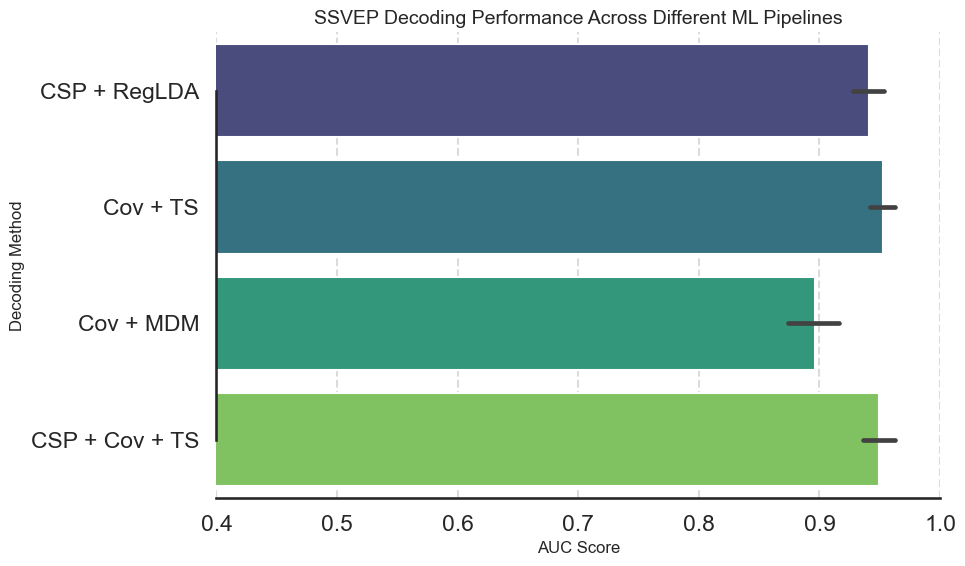

In [41]:
# Create a Pandas DataFrame to store the results
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

print("\nDecoding Results (AUC Scores):")
print(results.groupby('Method')['AUC'].agg(['mean', 'std']))

# Visualize the results using a bar plot
plt.figure(figsize=[10, 6])
sns.barplot(data=results, x='AUC', y='Method', palette='viridis')
plt.xlim(0.4, 1) # Set x-axis limits from chance level (0.5) to perfect (1.0)
plt.xlabel('AUC Score', fontsize=12)
plt.ylabel('Decoding Method', fontsize=12)
plt.title('SSVEP Decoding Performance Across Different ML Pipelines', fontsize=14)
sns.despine(trim=True) # Remove top and right spines for cleaner look
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## *8. Conclusion and Future Work*

This notebook successfully demonstrated how to load, preprocess, and decode SSVEP signals using various traditional machine learning pipelines. We observed the performance of different approaches (CSP, Riemannian Geometry, etc.) in classifying visual attention to 20 Hz versus 30 Hz stimuli.

**Key Takeaways:**

  * The **Filter Bank Approach** is effective for isolating frequency-specific SSVEP responses.
  * **Cross-validation** provides a robust estimate of model performance, mitigating overfitting.
  * Different **ML pipelines** exhibit varying performance, suggesting the importance of method selection for specific data characteristics.

**Future Work and Enhancements:**

  * **Hyperparameter Tuning:** Systematically optimize the hyperparameters of the best-performing pipelines (e.g., `CSP(n_components)`, `LogisticRegression` `C` parameter, filter band edges) using techniques like `GridSearchCV` or `RandomizedSearchCV`.
  * **More Data:** Test the pipelines on more subjects and sessions to assess generalization.
  * **Artifact Rejection:** Explore more sophisticated artifact rejection techniques beyond simple amplitude thresholds (e.g., ICA, ASR).
  * **Other Features:** Experiment with different feature extraction methods (e.g., power spectral density, connectivity measures).
  * **Real-time Decoding:** Adapt the pipeline for real-time BCI applications.
  * **Deep Learning:** Explore deep learning models (e.g., CNNs or RNNs) for end-to-end SSVEP decoding, which can automatically learn features from raw or epoched data.